In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import yaml

from evolution.evaluation.evaluator import EnROADSEvaluator
from evolution.utils import process_config
from experiments.experiment_utils import NNExperimenter, DirectExperimenter
from enroadspy import load_input_specs
from enroadspy.generate_url import open_browser

In [2]:
results_dir = Path("results/app1")
with open(results_dir / "config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

config = process_config(config)

print(config)

gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
outcome_keys = list(outcomes.keys())
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes, len(actions), len(context))

{'actions': [1, 2, 3, 211, 197, 196, 202, 203, 4, 7, 8, 9, 212, 199, 198, 204, 205, 10, 11, 12, 213, 201, 200, 206, 207, 16, 17, 18, 311, 23, 24, 25, 313, 314, 292, 293, 294, 30, 31, 32, 39, 40, 41, 42, 43, 44, 312, 298, 263, 264, 265, 414, 267, 266, 268, 245, 247, 248, 249, 45, 46], 'batch_size': 64, 'context': [235, 64, 236, 63], 'decomplexify': True, 'device': 'mps', 'evolution_params': {'mutation_factor': 0.1, 'mutation_rate': 0.1, 'n_elites': 0, 'n_generations': 200, 'population_size': 100, 'remove_population_pct': 0.0, 'save_path': 'results/app1', 'seed_dir': 'evolution/seeding/seeds/app'}, 'model_params': [{'in_features': 4, 'out_features': 64, 'type': 'linear'}, {'type': 'tanh'}, {'in_features': 64, 'out_features': 64, 'type': 'linear'}, {'type': 'tanh'}, {'in_features': 64, 'out_features': 61, 'type': 'linear'}, {'type': 'sigmoid'}], 'n_jobs': -1, 'outcomes': {'Government net revenue below zero': True, 'Max cost of energy': True, 'Temperature change from 1850': True, 'Total en

In [3]:
input_specs = load_input_specs()

evaluator = EnROADSEvaluator(context, actions, outcomes, n_jobs=1, batch_size=config["batch_size"], device=config["device"])
if len(context) > 0:
    experimenter = NNExperimenter(results_dir)
else:
    experimenter = DirectExperimenter(results_dir)

make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.
make: `enroads' is up to date.


In [4]:
def get_search_space_size(actions: list[str]):
    input_specs = load_input_specs()
    size = 1
    for action in actions:
        row = input_specs[input_specs["id"] == action].iloc[0]
        if row["kind"] == "switch":
            size *= 2
        elif row["kind"] == "slider":
            combs = int((row["maxValue"] - row["minValue"]) / row["step"])
            size *= combs
    
    size = int(size)
    return size

size = get_search_space_size(actions)
n_atoms = 1e82
print(f"{size:.2e}")
f"{size / n_atoms:.2e}"

1.72e+96


'1.72e+14'

In [5]:
baseline_actions = {}
baseline_df = evaluator.enroads_runner.evaluate_actions(baseline_actions)
baseline_metrics = evaluator.outcome_manager.process_outcomes(baseline_actions, baseline_df)
for outcome in outcomes:
    print(f"{outcome}: {baseline_metrics[outcome]}")

Government net revenue below zero: 0
Max cost of energy: 24.9071
Temperature change from 1850: 3.32279
Total energy below baseline: -0.0


In [6]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,cv,rank,distance,Temperature change from 1850,Max cost of energy,Government net revenue below zero,Total energy below baseline
0,94_94,"['92_83', '89_18']",0,1,inf,2.615914,21.89870,390.914885,61.8072
1,129_10,"['101_58', '101_58']",0,1,inf,2.824568,21.89870,123.805183,56.8378
2,145_74,"['129_48', '129_48']",0,1,inf,2.494506,21.89870,0.000000,220.6860
3,185_35,"['181_23', '181_23']",0,1,inf,1.928338,78.69950,600.910700,8119.1154
4,189_6,"['187_97', '185_14']",0,1,inf,1.913562,75.48810,340.663500,18055.6460
...,...,...,...,...,...,...,...,...,...
95,199_86,"['195_77', '166_95']",0,1,0.049786,2.115564,34.08118,0.011472,10479.8482
96,198_68,"['193_50', '193_2']",0,1,0.049280,2.201304,23.44752,0.000000,2981.5266
97,177_95,"['175_37', '166_9']",0,1,0.048886,2.343622,21.89870,243.639370,379.9924
98,198_39,"['181_19', '150_31']",0,1,0.048740,2.352312,21.99894,81.310539,396.6272


In [7]:
context_input, context_vals = evaluator.context_dataset[0]

In [8]:
def evenly_sample(lst, m):
    middle = lst[1:-1]
    step = len(middle) / (m-2)
    sample = [middle[int(i * step)] for i in range(m-2)]
    sample = [lst[0]] + sample + [lst[-1]]
    return sample

In [9]:
if len(final_pareto) < 10:
    sample_points = final_pareto["cand_id"].tolist()
else:
    outcome_sort = outcome_keys[1]
    sample_points = final_pareto.sort_values(outcome_sort, ascending=outcomes[outcome_sort])["cand_id"].tolist()
    sample_points = evenly_sample(sample_points, 9)

    # sample_pareto = final_pareto[final_pareto["Temperature change from 1850"] <= 1.5].sort_values("Cost change year", ascending=False)
    # sample_points = evenly_sample(sample_pareto["cand_id"].tolist(), 9)
    # sample_pareto

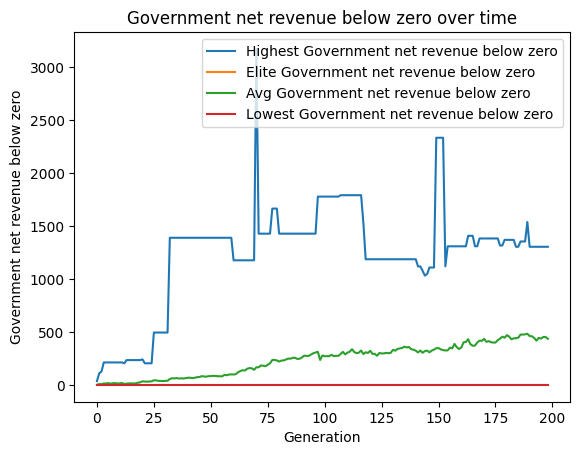

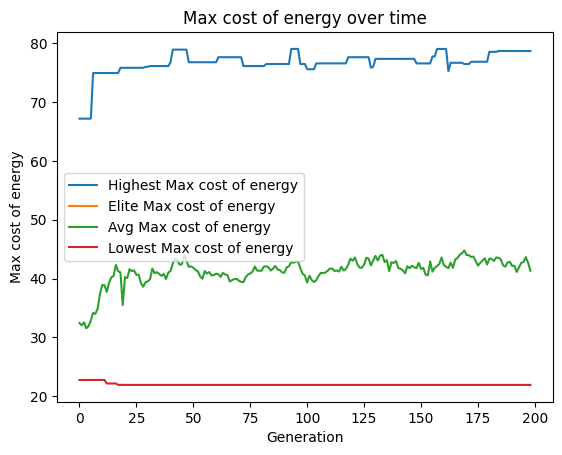

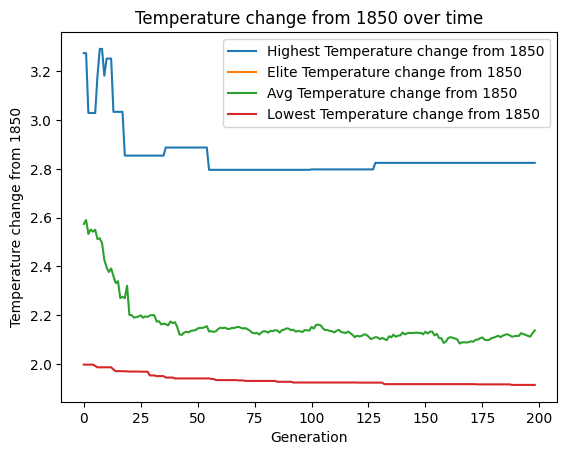

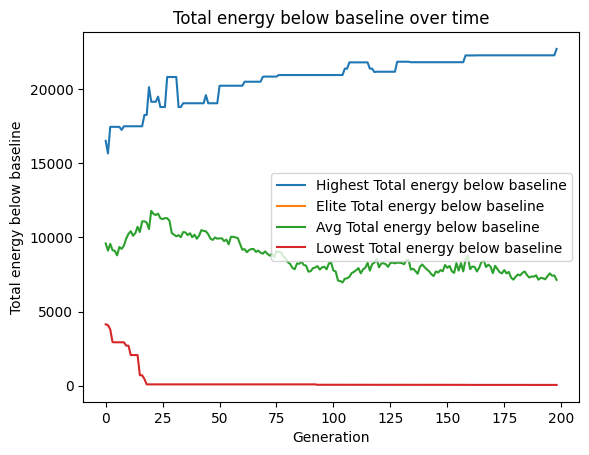

In [10]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(1, gens+1):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto.sort_values("distance", ascending=False)[outcome]
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.iloc[:n_elites].mean())
    
    # plt.plot(range(gens), [baseline_df[outcome].iloc[-1] for _ in range(gens)], label=f"Baseline {outcome}", color="black")

    plt.plot(range(gens), best, label=f"Highest {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Lowest {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

In [11]:
def plot_two_objective(outcome1, outcome2, gens, pareto=True):

    gen_dfs = []
    for gen in gens:
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        gen_df = gen_df[gen_df["rank"] == 1] if pareto else gen_df
        gen_df["color"] = gen
        gen_dfs.append(gen_df)
    
    total_gen_df = pd.concat(gen_dfs)
    cmap = "viridis_r" if len(gens) != 1 else "viridis"
    fig, ax = plt.subplots()
    scatter = ax.scatter(total_gen_df[outcome1], total_gen_df[outcome2], c=total_gen_df["color"], cmap=cmap)

    title = f"{outcome1} vs {outcome2} Final Pareto"

    if len(gens) != 1:
        cbar = fig.colorbar(scatter)
        cbar.set_label("Generation", rotation=270, labelpad=15)
        title = f"{outcome1} vs {outcome2} over Evolution"
    
    ax.set_title(title)

    ax.set_ylabel(outcome2)
    ax.set_xlabel(outcome1)
    plt.show()

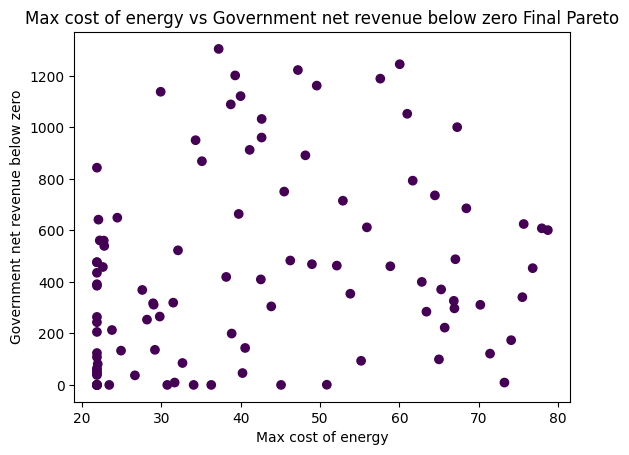

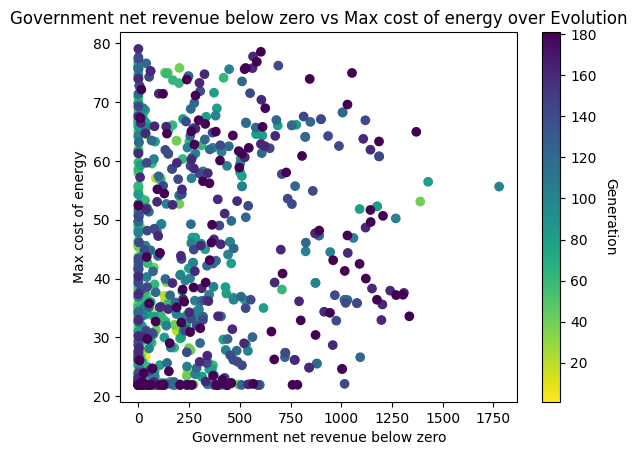

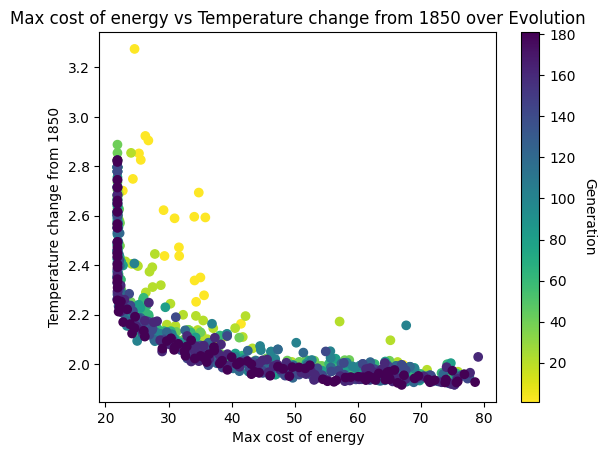

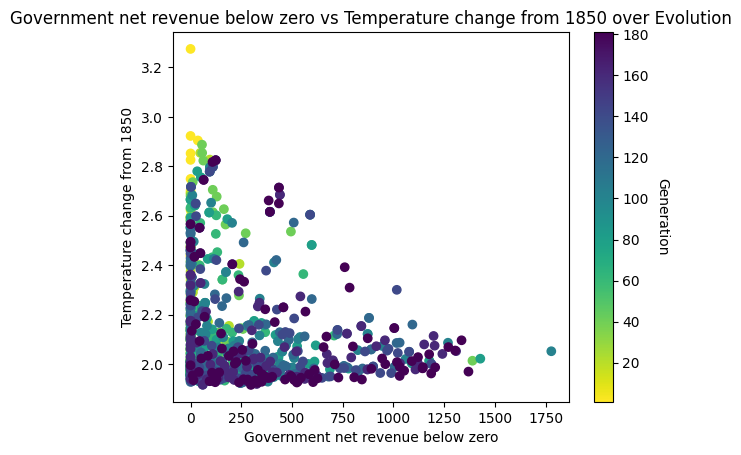

In [12]:
plot_two_objective(outcome_keys[1], outcome_keys[0], [gens])
plot_two_objective(outcome_keys[0], outcome_keys[1], range(1, gens+1, 20))
plot_two_objective(outcome_keys[1], outcome_keys[2], range(1, gens+1, 20))
plot_two_objective(outcome_keys[0], outcome_keys[2], range(1, gens+1, 20))

In [13]:
best_cand_ids = []
for outcome, ascending in outcomes.items():
    best_cand_ids.append(final_pareto.sort_values(outcome, ascending=ascending).iloc[0]["cand_id"])
    print(final_pareto.sort_values(outcome, ascending=ascending).iloc[0][outcome_keys])
    print()
best_cand_ids = list(set(best_cand_ids))
best_cand_ids

Government net revenue below zero         0.0
Max cost of energy                    21.8987
Temperature change from 1850         2.566078
Total energy below baseline          114.4952
Name: 86, dtype: object

Government net revenue below zero    390.914885
Max cost of energy                      21.8987
Temperature change from 1850           2.615914
Total energy below baseline             61.8072
Name: 0, dtype: object

Government net revenue below zero     340.6635
Max cost of energy                     75.4881
Temperature change from 1850          1.913562
Total energy below baseline          18055.646
Name: 4, dtype: object

Government net revenue below zero    475.966644
Max cost of energy                      21.8987
Temperature change from 1850           2.683516
Total energy below baseline             51.5436
Name: 6, dtype: object



['189_6', '159_87', '198_8', '94_94']

   cand_id               parents  cv  rank  distance  \
0    94_94    ['92_83', '89_18']   0     1       inf   
3   185_35  ['181_23', '181_23']   0     1       inf   
7   199_33  ['193_50', '174_35']   0     1       inf   
15   179_4   ['173_17', '176_5']   0     1  0.097437   
18  194_79  ['176_75', '176_75']   0     1  0.094812   
24  161_82  ['160_92', '156_31']   0     1  0.082818   
26  196_43  ['192_29', '195_53']   0     1  0.081518   
35   195_6  ['187_72', '177_95']   0     1  0.076181   
97  177_95   ['175_37', '166_9']   0     1  0.048886   

    Temperature change from 1850  Max cost of energy  \
0                       2.615914            21.89870   
3                       1.928338            78.69950   
7                       1.918582            65.70448   
15                      2.033462            32.67582   
18                      2.007246            41.13616   
24                      2.403902            21.89870   
26                      1.962434            52.

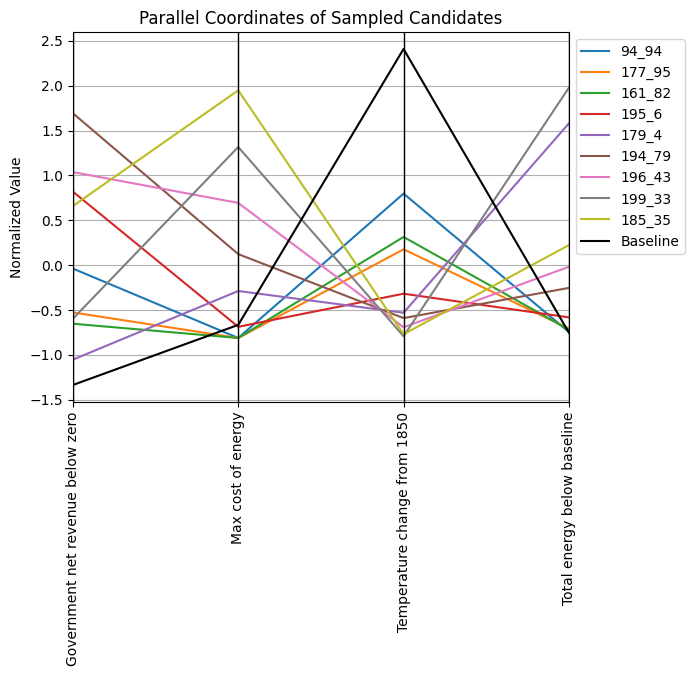

In [14]:
def plot_parallel_coordinates(cand_ids):
    coords_dicts = []
    for cand_id in cand_ids:
        gen = int(cand_id.split("_")[0])
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        row = gen_df[gen_df["cand_id"] == cand_id].iloc[0]
        cand_coords = [row[outcome] for outcome in outcomes]
        cand_dict = dict(zip(outcomes.keys(), cand_coords))
        cand_dict["cand_id"] = cand_id
        coords_dicts.append(cand_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    colors[len(coords_df)-1] = "black" 
    pd.plotting.parallel_coordinates(normalized_df, "cand_id", color=colors)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")

plot_parallel_coordinates(sample_points)
print(final_pareto[final_pareto["cand_id"].isin(sample_points)])

In [15]:
def get_average_df(dfs: list[pd.DataFrame]):
    avg_df = dfs[0].copy()
    for df in dfs[1:]:
        avg_df += df
    avg_df /= len(dfs)
    return avg_df

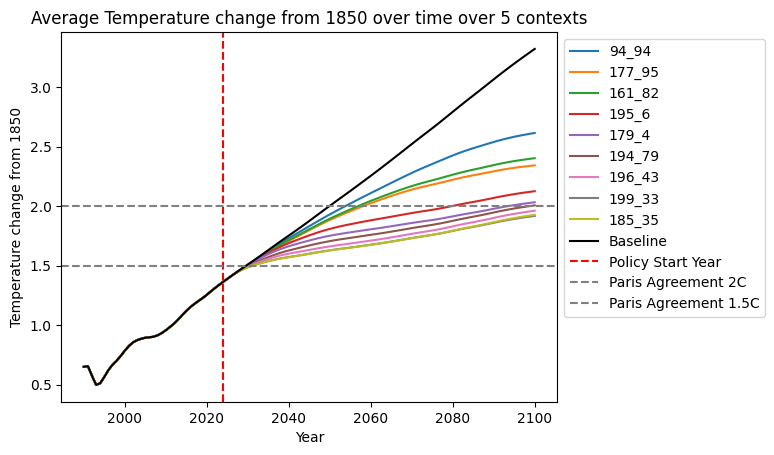

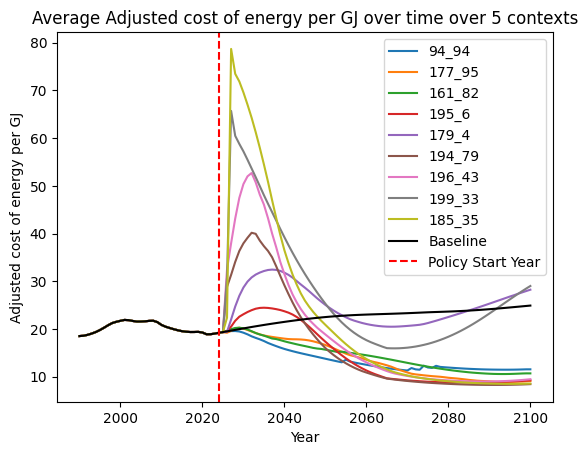

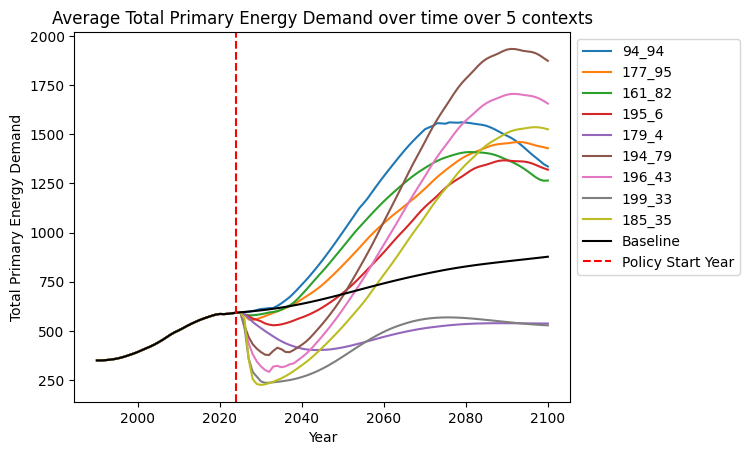

In [16]:
def plot_outcome_over_time(outcome, cand_ids, paris=False):
    for cand_id in cand_ids:
        _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
        avg_df = get_average_df(cand_outcomes)
        plt.plot(range(1990, 2101), avg_df[outcome], label=f"{cand_id}")
    plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
    plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")

    if outcome == "CO2 Equivalent Net Emissions":
        plt.axhline(y=0, color="gray", linestyle="--")
        if paris:
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")

    elif outcome == "Temperature change from 1850":
        plt.axhline(y=2, color="gray", linestyle="--", label="Paris Agreement 2C")
        plt.axhline(y=1.5, color="gray", linestyle="--", label="Paris Agreement 1.5C")

    plt.legend(bbox_to_anchor=(1, 1))
    if len(cand_outcomes) > 1:
        plt.title(f"Average {outcome} over time over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"{outcome} over time")
    plt.xlabel("Year")
    plt.ylabel(outcome)
    plt.show()

paris = "Emissions Above Paris Agreement" in outcomes
enroads_outcomes = ["Temperature change from 1850", "Adjusted cost of energy per GJ", "Total Primary Energy Demand"]
for outcome in enroads_outcomes:
    plot_outcome_over_time(outcome, sample_points, paris)

In [17]:
def plot_energy_usage(cand_ids):
    fig, axes = plt.subplots(1, len(cand_ids), sharey=True, figsize=(7.5 * len(cand_ids), 5))
    if len(cand_ids) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_ids, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
            cand_outcomes = get_average_df(cand_outcomes)
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [
            "Primary Energy Demand of coal",
            "Primary Energy Demand of oil",
            "Primary Energy Demand of gas",
            "Primary Energy Demand of renew and hydro",
            "Primary Energy Demand of bio",
            "Primary energy demand of nuclear",  # NOTE: There is weird capitalization here so we have to match it
            "Primary energy demand of new tech",
        ]

        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            if energy_df[demand].sum() == 0:
                continue
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    plt.show()

In [18]:
def plot_energy_difference(cand_id):
    colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
    energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
    demands = [
        "Primary Energy Demand of coal",
        "Primary Energy Demand of oil",
        "Primary Energy Demand of gas",
        "Primary Energy Demand of renew and hydro",
        "Primary Energy Demand of bio",
        "Primary energy demand of nuclear",  # NOTE: There is weird capitalization here so we have to match it
        "Primary energy demand of new tech",
    ]

    _, cand_outcomes, _ = experimenter.get_candidate_results(cand_id)
    avg_outcomes = get_average_df(cand_outcomes)
    energy_df = avg_outcomes[demands]

    energy_baseline = baseline_df[demands]

    diff_df = energy_df - energy_baseline
    plt.grid(axis="y")
    plt.bar(energies, diff_df.iloc[-1], color=colors)
    plt.ylabel("Difference in Energy (Exajoules / year)")
    plt.xlabel("Energy Source")
    if len(cand_outcomes) > 1:
        plt.title(f"Average Difference in Energy from Baseline for {cand_id} in 2100 over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"Difference in Energy from Baseline for {cand_id} in 2100")
    plt.xticks(rotation=90)
    plt.show()

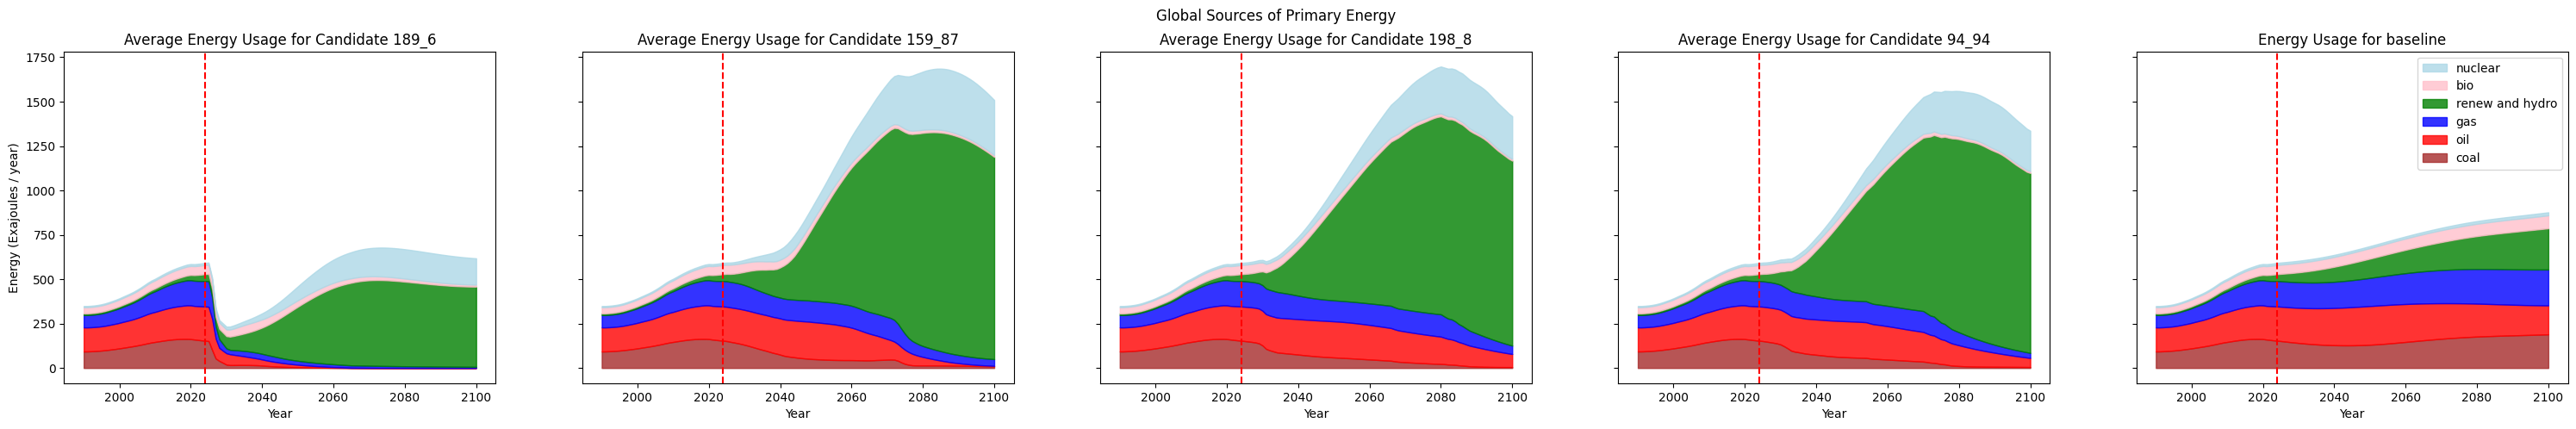

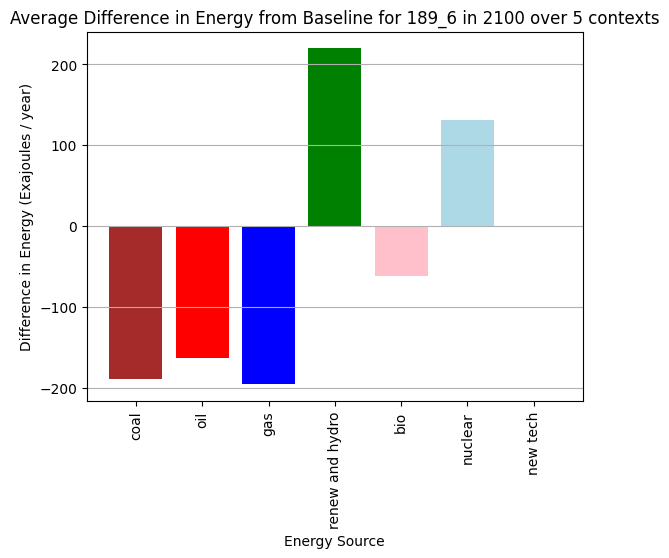

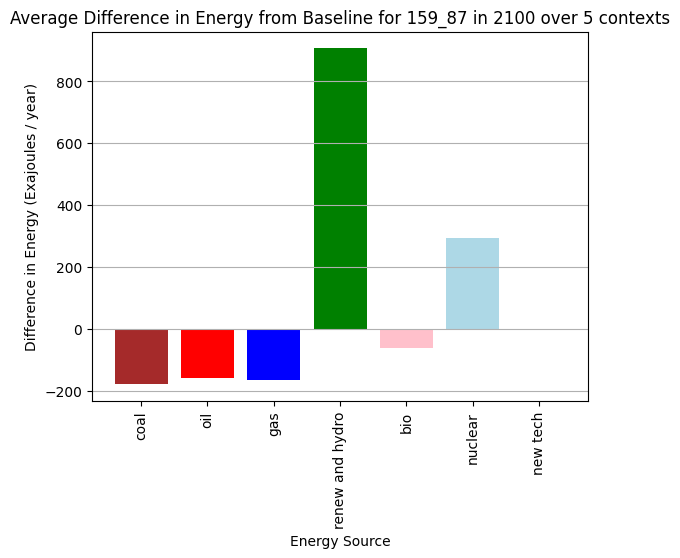

In [19]:
examples = best_cand_ids
plot_energy_usage(examples +  ["baseline"])
plot_energy_difference(examples[0])
plot_energy_difference(examples[1])

In [20]:
# Uncomment to open the browser for each example
# for example in examples:
#     open_browser(results_dir, example, 0)